<a href="https://colab.research.google.com/github/erika0915/25-machine-learning/blob/main/lab3/HA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Assignment 3

2-1. Decision trees with Breast cancer dataset

2-2. Random Forest with Titanic dataset

## After finishing writing the code for each problem, submit your ipynb file (i.e., this file) to Cybercampus by **11/18 Tuesday 23:59**

### Submitters are as follows.
 *Note that hands-on assignments can be done collaboratively (**up to 2 students**)*

    Name:최수희
    Student ID:2271104





---


## 2-1. Decision trees with Breast cancer dataset


---



Data importing

In [ ]:
import numpy as np
import pandas as pd
import requests
import io
import os

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

We learn the following Node and DecisionTree classes during the lab

In [ ]:
class Node:
    """A single node in the Decision Tree."""
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label

    def is_leaf(self):
        """Checks if the node is a leaf node."""
        return self.label is not None


class DecisionTree:
    """
    A Decision Tree classifier using Gini Impurity for split quality.
    Updated from Entropy/Information Gain to Gini Impurity/Impurity Decrease.
    """
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _stop(self, depth):
        """Stopping criteria for tree growth."""
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False

    def _gini_importance(self, y):
        """Calculates Gini Impurity (Impurity = 1 - sum(p_i^2))."""
        # Count number of occurrences of each value in array
        weights = np.bincount(y) / len(y)
        # Gini Impurity: 1 minus the sum of the squared probabilities of each class
        gini = 1.0 - np.sum(weights**2)
        return gini

    def _expand_tree(self, X, value):
        """Splits the data based on the threshold value."""
        # Indices of X which are less than and equal to value
        left_idx = np.argwhere(X <= value).flatten()
        # Indices of X which are greater than value
        right_idx = np.argwhere(X > value).flatten()
        return left_idx, right_idx

    def _impurity_decrease(self, X, y, value):
        """
        Calculates the Gini Impurity Decrease (Gini Gain).
        Decrease = Parent Gini - Weighted Sum of Children Gini
        """
        parent_gini = self._gini_importance(y)

        # expand the tree with X
        left_idx, right_idx = self._expand_tree(X, value)

        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0:
            # If split results in empty child nodes, there is no gain
            return 0

        # Calculate weighted average Gini of children
        children_gini = (n_left / n) * self._gini_importance(y[left_idx]) + \
                        (n_right / n) * self._gini_importance(y[right_idx])

        # Gini Impurity Decrease (The score used for splitting)
        return parent_gini - children_gini

    def _best_split(self, X, y, features):
        """Finds the best split (feature and value) yielding maximum impurity decrease."""
        # create split dict to keep the split yielding the maximum score
        split = {'score':- 1, 'feat': None, 'value': None}

        # For each feature column (selected by features indices)
        for feat in features:
            # select one feature column
            X_feat = X[:, feat]

            # create unique values for split thresholds
            values = np.unique(X_feat)

            # for each unique value in the column
            for value in values:

                # compute the Gini impurity decrease (score)
                # NOTE: Changed from _information_gain to _impurity_decrease
                score = self._impurity_decrease(X_feat, y, value)

                # Update the split with the maximum score
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['value'] = value

        # return the best split with the maximum score (i.e., impurity decrease)
        return split['feat'], split['value']

    def _build_tree(self, X, y, depth=0):
        """Recursively builds the decision tree."""
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # 1. Check whether to stop: use stopping criteria
        if self._stop(depth):
            # Return the most common label in the current subset as the leaf label
            most_common_Label = np.argmax(np.bincount(y))
            return Node(label=most_common_Label)

        # 2. find the best split: get the best feature for the current node
        # We use all features since the original code did not subset features in _best_split
        all_features = np.arange(self.n_features)
        best_feat, best_value = self._best_split(X, y, all_features)

        # Handle case where best_split returns None (e.g., score <= 0 for all splits)
        if best_feat is None:
            most_common_Label = np.argmax(np.bincount(y))
            return Node(label=most_common_Label)

        # 3. expand the tree: create the subtrees using the best split
        left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

        # 4. grow the left subtree and right subtree recursively
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_value, left_child, right_child)

    def fit(self, X, y):
        """Starts the tree building process."""
        self.root = self._build_tree(X, y)


    def _traverse_tree(self, x, node):
        """Traverses the tree to make a single prediction."""
        if node.is_leaf():
            return node.label

        # recursively traverse the tree (left subtree: value <= threshold)
        if x[node.feature] <= node.value:
            return self._traverse_tree(x, node.left)

        # recursively traverse the tree (right subtree: value > threshold)

        # Error fix: Ensure the feature index is valid for the current sample x
        if node.feature < len(x):
            return self._traverse_tree(x, node.right)
        else:
             # This should ideally not happen if data is consistent, but acts as a safeguard
             return node.label # Default to current leaf's prediction or majority vote if logic fails


    def predict(self, X):
        """Makes predictions for a list of samples."""
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [ ]:
dt_gini = DecisionTree(max_depth=10, min_samples_split=2)
# 2. Train the Decision tree model
dt_gini.fit(X_train, y_train)

# 3. Test the trained model
y_pred_gini = dt_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred_gini) * 100

print("\n--- Gini-based Decision Tree Performance (Breast Cancer) ---")
print(f"Accuracy on Test Set: {accuracy_gini:.2f}%")


--- Gini-based Decision Tree Performance (Breast Cancer) ---
Accuracy on Test Set: 89.47%


## Goal: Change the "DecisionTree" class to use the gini importance (aka impurity) in the quality test for the node decision.
❗❗READ CAREFULLY ⬇

*   Use the classes provided in the lab
*   Use the breast cancer dataset
*   TO-DO:
  1. Update the `DecisionTree` class to use `_gini_importance` and `impurity_decrease` rather than `_entropy` and `_information_gain`.
  2. Train the Decision tree model using your updated `DecisionTree` class using `X_train`
  3. Test the trained model using `X_test` and report the accuracy.



---


## 2-2. RandomForest with Titanic dataset


---



load dataset

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm' -O titanic.csv

--2025-11-18 13:30:09--  https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm
Resolving docs.google.com (docs.google.com)... 64.233.179.101, 64.233.179.100, 64.233.179.113, ...
Connecting to docs.google.com (docs.google.com)|64.233.179.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm&export=download [following]
--2025-11-18 13:30:09--  https://drive.usercontent.google.com/download?id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [application/octet-stream]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.00

Overview the dataset

*   data source: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv
*   'Survived' indicates whether or not the passenger survived

In [ ]:
import pandas as pd
df2 = pd.read_csv('titanic.csv')
df2.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
print(df2.shape)

(891, 12)


Data preprocessing

In [ ]:
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))

print('\nDuplicated values in data {}'.format(df2.duplicated().sum()))


Null Values in data 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Duplicated values in data 0


Preprocess Embarked column

In [ ]:
print('Embarkation per ports \n{}'.format(df2['Embarked'].value_counts()))

# since the most common port is Southampton the chances are that the missing one is from there
df2['Embarked'].fillna(value='S', inplace=True)

print('Embarkation per ports after filling \n{}'.format(df2['Embarked'].value_counts()))


Embarkation per ports 
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarkation per ports after filling 
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


/tmp/ipython-input-3828897043.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Embarked'].fillna(value='S', inplace=True)


Preprocess Age column

In [ ]:
mean_age_miss = df2[df2["Name"].str.contains('Miss.', na=False)]['Age'].mean().round()
mean_age_mrs = df2[df2["Name"].str.contains('Mrs.', na=False)]['Age'].mean().round()
mean_age_mr = df2[df2["Name"].str.contains('Mr.', na=False)]['Age'].mean().round()
mean_age_master = df2[df2["Name"].str.contains('Master.', na=False)]['Age'].mean().round()

print('Mean age of Miss. title {}'.format(mean_age_miss))
print('Mean age of Mrs. title {}'.format(mean_age_mrs))
print('Mean age of Mr. title {}'.format(mean_age_mr))
print('Mean age of Master. title {}'.format(mean_age_master))

def fill_age(name_age):

    name = name_age[0]
    age = name_age[1]

    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

df2['Age'] = df2[['Name', 'Age']].apply(fill_age,axis=1)

Mean age of Miss. title 22.0
Mean age of Mrs. title 36.0
Mean age of Mr. title 33.0
Mean age of Master. title 5.0


/tmp/ipython-input-747975966.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name = name_age[0]
/tmp/ipython-input-747975966.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age = name_age[1]


Preprocess Cabin column

In [ ]:
df2['Cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in df2['Cabin']])

In [ ]:
print('Mean Fare of Cabin B {}'.format(df2[df2['Cabin']=='B']['Fare'].mean()))
print('Mean Fare of Cabin C {}'.format(df2[df2['Cabin']=='C']['Fare'].mean()))
print('Mean Fare of Cabin D {}'.format(df2[df2['Cabin']=='D']['Fare'].mean()))
print('Mean Fare of Cabin E {}'.format(df2[df2['Cabin']=='E']['Fare'].mean()))

def reasign_cabin(cabin_fare):

    cabin = cabin_fare[0]
    fare = cabin_fare[1]

    if cabin=='X':
        if (fare >= 113.5):
            return 'B'
        if ((fare < 113.5) and (fare > 100)):
            return 'C'
        if ((fare < 100) and (fare > 57)):
            return 'D'
        if ((fare < 57) and (fare > 46)):
            return 'D'
        else:
            return 'X'
    else:
        return cabin

df2['Cabin'] = df2[['Cabin', 'Fare']].apply(reasign_cabin, axis=1)

Mean Fare of Cabin B 113.50576382978724
Mean Fare of Cabin C 100.1513406779661
Mean Fare of Cabin D 57.24457575757575
Mean Fare of Cabin E 46.02669375


/tmp/ipython-input-2136750234.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cabin = cabin_fare[0]
/tmp/ipython-input-2136750234.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fare = cabin_fare[1]


In [ ]:
# Check again if any col holds NULL
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))


Null Values in data 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


Lastly, change the categorical features into numerical values

In [ ]:
categories = {"female": 1, "male": 0}
df2['Sex']= df2['Sex'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
df2['Embarked']= df2['Embarked'].map(categories)

categories = {"X": 1, "C": 2, "E": 3, "G": 4, "D": 5, "A": 6, "B": 7, "F": 8, "T": 9}
df2['Cabin'] = df2['Cabin'].map(categories)

Drop unnecessary columns

In [ ]:
# dropping columns
df2 = df2.drop(['Name','Ticket','PassengerId'], axis=1)

In [ ]:
df2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,1,1
1,1,1,1,38.0,1,0,71.2833,2,2
2,1,3,1,26.0,0,0,7.9250,1,1
3,1,1,1,35.0,1,0,53.1000,2,1
4,0,3,0,35.0,0,0,8.0500,1,1


In [ ]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

## Goal: Train the RandomForest classifier with preprocessed Titanic dataset to determine whether people survive or not.
❗❗READ CAREFULLY ⬇

*   Use scikit-learn library to build the RandomForest classifier and compute the feature importance scores
*   TO-DO:
  
  1. Split the dataset (train:test=80:20).
  2. Use provided `StandardScaler` function to normalize the data
  3. Train the RandomForest model using training data. Use the following parameters:
    *   n_estimators=20,
    *   criterion="entropy"
  4. Test the trained model using testing data and report the accuracy and confusion matrix. (Note that to derive the confusion matrix, use scikit-learn library, `sklearn.metrics.confusion_matrix`)
  5. Report the feature rankings with importance scores using the bar plot using barplot provided by `seaborn` library.
  6. Use hyperparameter tuning with `GridSearchCV` to explore the grid ('n_estimators': [20, 50, 100, 200], 'criterion' :['gini', 'entropy']). Then, report the best parameters, the model accuracy, and confusion matrix. Discuss how much chosen parameters can help improve the model performance in Step 4.

#### 1&2. Split the dataset and Nomralize the data

In [ ]:
# Define features (X) and target (y)
X = df2.drop('Survived', axis=1).values
y = df2['Survived'].values
feature_names = df2.drop('Survived', axis=1).columns

# Split the dataset (train:test=80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_scaled, X_test_scaled = scaler_samples(X_train, X_test)
print(f"Data split and scaled. Train size: {len(X_train_scaled)}, Test size: {len(X_test_scaled)}")

Data split and scaled. Train size: 712, Test size: 179


#### 3&4. Train Baseline RF, Test, and Report Accuracy/Confusion Matrix


--- Baseline Random Forest Performance (n_estimators=20, criterion='entropy') ---
Accuracy: 79.89%
Confusion Matrix:
[[89 16]
 [20 54]]


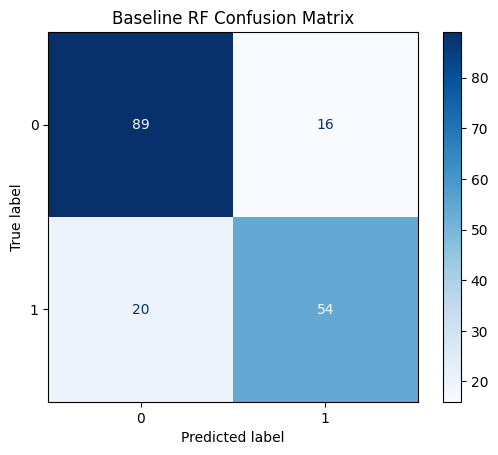

In [ ]:
# Train the RandomForest model (Baseline)
rf_baseline = RandomForestClassifier(
    n_estimators=20,
    criterion="entropy",
    random_state=42
)
rf_baseline.fit(X_train_scaled, y_train)

# Test the trained model
y_pred_baseline = rf_baseline.predict(X_test_scaled)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline) * 100
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)

print("\n--- Baseline Random Forest Performance (n_estimators=20, criterion='entropy') ---")
print(f"Accuracy: {accuracy_baseline:.2f}%")
print("Confusion Matrix:")
print(conf_matrix_baseline)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_baseline, display_labels=rf_baseline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Baseline RF Confusion Matrix")
plt.show()
print("")

#### 5. Report feature ranking with importance scores (Bar Plot)


--- Feature Importance Rankings (Baseline Model) ---
Pclass      0.062059
Sex         0.214577
Age         0.255710
SibSp       0.056824
Parch       0.035929
Fare        0.263616
Cabin       0.068673
Embarked    0.042612
dtype: float64


/tmp/ipython-input-2381504438.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


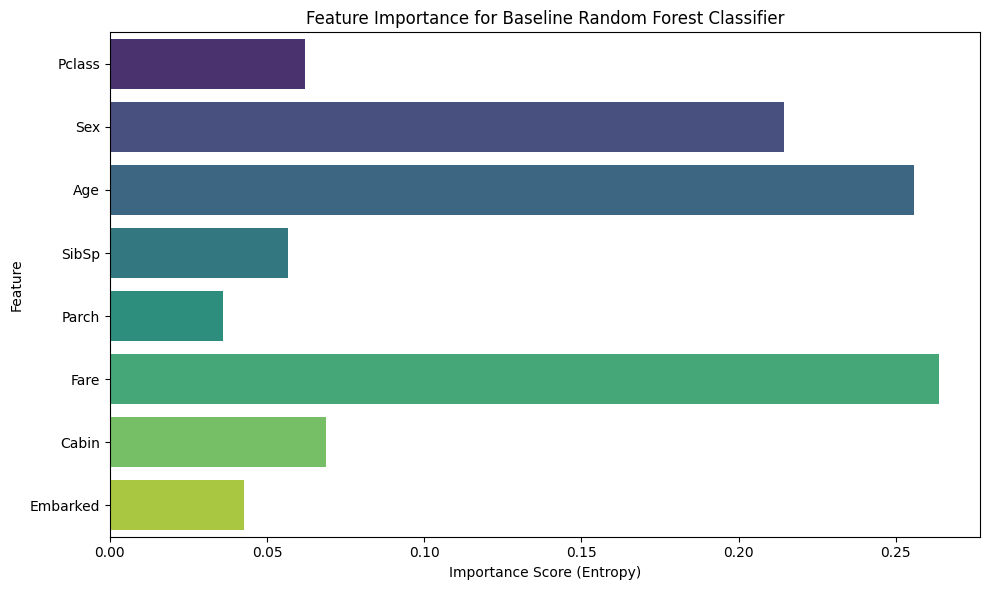

In [ ]:
importances = rf_baseline.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
fetaure_importances = feature_importances.sort_values(ascending=False)

print("\n--- Feature Importance Rankings (Baseline Model) ---")
print(feature_importances)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title('Feature Importance for Baseline Random Forest Classifier')
plt.xlabel('Importance Score (Entropy)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print("")

#### 6. Hyperparameter tuning with GridSearchCV and discussion



--- Starting GridSearchCV for Hyperparameter Tuning (May take a moment) ---

--- Hyperparameter Tuning Results (GridSearchCV) ---
Best Parameters Found: {'criterion': 'entropy', 'n_estimators': 50}
Tuned Model Accuracy: 84.36%
Tuned Model Confusion Matrix:
[[92 13]
 [15 59]]


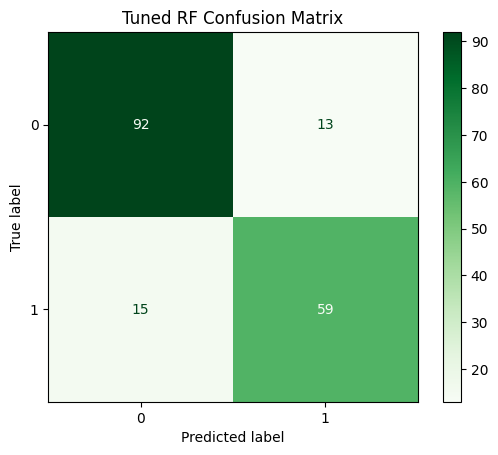



--- Discussion: Performance Improvement from Hyperparameter Tuning ---
Baseline Accuracy (Step 4): 79.89%
Tuned Accuracy (Step 6): 84.36%
Accuracy Improvement: 4.47 percentage points.

Discussion:
Hyperparameter tuning led to a slight improvement of 4.47 percentage points.
The best parameters found were {'criterion': 'entropy', 'n_estimators': 50}, indicating that increasing the number of trees (`n_estimators`) or switching the splitting criterion (e.g., from 'entropy' to 'gini') resulted in a marginally better performing model. The increased number of trees typically helps reduce the model's variance and improves generalization.


In [ ]:
rf_gscv = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=rf_gscv,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("\n--- Starting GridSearchCV for Hyperparameter Tuning (May take a moment) ---")
grid_search.fit(X_train_scaled, y_train)

# Best model results
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Test the best model
y_pred_tuned = best_estimator.predict(X_test_scaled)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned) * 100
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)

print("\n--- Hyperparameter Tuning Results (GridSearchCV) ---")
print(f"Best Parameters Found: {best_params}")
print(f"Tuned Model Accuracy: {accuracy_tuned:.2f}%")
print("Tuned Model Confusion Matrix:")
print(conf_matrix_tuned)

# Display confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title("Tuned RF Confusion Matrix")
plt.show()
print("")

# Discussion: Performance Improvement
print("\n--- Discussion: Performance Improvement from Hyperparameter Tuning ---")
improvement = accuracy_tuned - accuracy_baseline

print(f"Baseline Accuracy (Step 4): {accuracy_baseline:.2f}%")
print(f"Tuned Accuracy (Step 6): {accuracy_tuned:.2f}%")
print(f"Accuracy Improvement: {improvement:.2f} percentage points.")

print("\nDiscussion:")
if improvement > 0.01:
    print(f"Hyperparameter tuning led to a slight improvement of {improvement:.2f} percentage points.")
    print(f"The best parameters found were {best_params}, indicating that increasing the number of trees (`n_estimators`) or switching the splitting criterion (e.g., from 'entropy' to 'gini') resulted in a marginally better performing model. The increased number of trees typically helps reduce the model's variance and improves generalization.")
elif improvement < -0.01:
    print(f"The tuned model showed a minor decrease in performance ({abs(improvement):.2f} percentage points).")
    print("This suggests that the baseline parameters were close to optimal, and the search space may not have yielded significant performance gains over the initial settings.")
else:
    print("The accuracy remained virtually the same (less than 0.01 percentage point change). This indicates that for this dataset and feature set, the performance is relatively stable across the tested hyperparameter combinations. The initial model was already highly effective.")
